## VCD 结果可视化
该脚本将VCD的多语言结果通过matplotlib可视化出来
### 1.导入必要的包

In [1]:
import os
import json
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt

from language_dict import language_dict

### 2.定义工具函数

In [2]:
def eval_pope(gt_file,gen_file,language='en'):
    # open ground truth answers
    gt_files = [json.loads(q) for q in open(os.path.expanduser(gt_file), "r")]
    # open generated answers
    gen_files = [json.loads(q) for q in open(os.path.expanduser(gen_file), "r")]
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    unknown = 0
    total_questions = len(gt_files)
    yes_answers = 0

    # compare answers
    for index, line in enumerate(gt_files):
        idx = line["question_id"]
        gt_answer = line["label"]
        assert idx == gen_files[index]["question_id"]
        gen_answer = gen_files[index]["text"]
        # convert to lowercase
        gt_answer = gt_answer.lower()
        gen_answer = gen_answer.lower()
        # strip
        gt_answer = gt_answer.strip()
        gen_answer = gen_answer.strip()
        # pos = 'yes', neg = 'no'
        pos = language_dict[language]['yes']
        neg = language_dict[language]['no']
        if pos in gt_answer or "yes" in gt_answer:
            if pos in gen_answer or "yes" in gen_answer:
                true_pos += 1
                yes_answers += 1
            else:
                false_neg += 1
        elif neg in gt_answer or "no" in gt_answer:
            if neg in gen_answer or "no" in gen_answer:
                true_neg += 1
            else:
                yes_answers += 1
                false_pos += 1
        else:
            print(f'Warning: unknown gt_answer: {gt_answer}')
            unknown += 1
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / total_questions
    yes_proportion = yes_answers / total_questions
    unknown_prop = unknown / total_questions
    
    res = {
        "language": language,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "yes_proportion": yes_proportion,
        "unknown_prop": unknown_prop
    }
    return res

def fetch_result():
    dataset_list=["coco"]
    type_list=["adversarial","popular","random"]
    # language_list=["en","es","de","fr","it","pt","ru","ja","ko","zh","ar"]
    languages = "en ar  bg  bn  de  el  es  fa  fr  gu  hi  id  it  ja  jv  ko  ml  mr  ms  my  nl  pt  ru  sv  sw  ta  te  th  tr  uk  ur  vi  zh"
    language_list = languages.split()
    dataset_res=[]
    for dataset in dataset_list:
        type_res=[]
        for type_item in type_list:
            language_res=[]
            for language in language_list:
                gt_file=f"/mnt/petrelfs/songmingyang/code/VCD/experiments/data/POPE/multi_lingual/{dataset}/{language}/{dataset}_pope_{type_item}_{language}.json"
                gen_file=f"/mnt/petrelfs/songmingyang/code/VCD/experiments/output/llava15_{dataset}_pope_{type_item}_answers_no_cd_seed55_{language}.jsonl"
                try:
                    language_res.append(eval_pope(gt_file,gen_file,language))
                except:
                    print(f"Error: {dataset} {type_item} {language}")
                
            sorted_language_res = sorted(language_res, key=lambda item: item['accuracy'], reverse=True)
            type_res.append({"type_name":type_item,"data":sorted_language_res})
        dataset_res.append({"dataset_name":dataset,"data":type_res})
    return dataset_res


### 3.定义画图函数

In [3]:
def draw():
    res = fetch_result()
    for dataset_res in res:
        for type_item in dataset_res["data"]:
            precision_list=[]
            recall_list=[]
            f1_list=[]
            accuracy_list=[]
            yes_proportion_list=[]
            unknown_prop_list=[]
            language_list=[]
            for language_res in type_item["data"]:
                language_list.append(language_res["language"])
                precision_list.append(language_res["precision"])
                recall_list.append(language_res["recall"])
                f1_list.append(language_res["f1"])
                accuracy_list.append(language_res["accuracy"])
                yes_proportion_list.append(language_res["yes_proportion"])
                unknown_prop_list.append(language_res["unknown_prop"])
            plt.figure()
            plt.title(f'{dataset_res["dataset_name"]}_{type_item["type_name"]}')
            plt.plot(precision_list,label=f'precision')
            plt.xticks(range(len(language_list)), language_list)
            plt.plot(recall_list,label=f'recall')
            plt.plot(f1_list,label=f'f1')
            plt.bar(language_list,accuracy_list,color='yellow',label=f'accuracy')
            plt.legend()
            # plt.plot(yes_proportion_list,label=f'{dataset_res["dataset_name"]}_{type_item["type_name"]}_yes_proportion')
            # plt.plot(unknown_prop_list,label=f'{dataset_res["dataset_name"]}_{type_item["type_name"]}_unknown_prop')

Error: coco adversarial nl
Error: coco random mr
Error: coco random th
Error: coco random uk


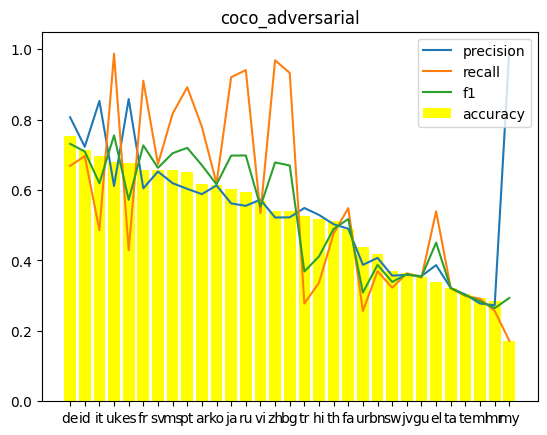

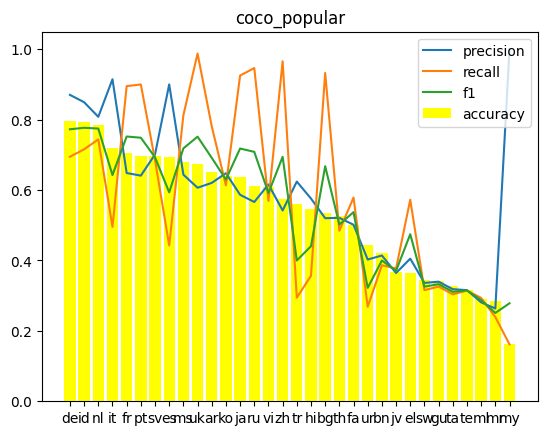

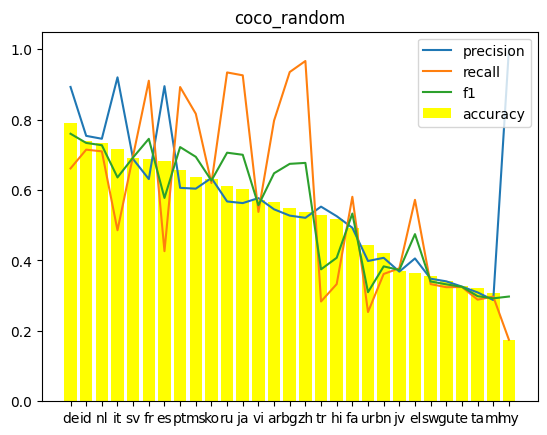

In [4]:
draw()